In [125]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd

In [126]:
# launch neoj4 browser and start an instance of the database
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", "1234"))


In [127]:
cypher_query = '''
MATCH (a:Officer {name:$name})-[r:officer_of|intermediary_of|registered_address*..10]-(b)
RETURN b.name as name LIMIT 20
'''

### Github Example Query

In [128]:
with driver.session(database="neo4j") as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query,
                      name="Ross, Jr. - Wilbur Louis").data())
    
    for record in results:
        print(record['name'])

driver.close()

WL Ross & Co. LLC; 1166 Avenue of the Americas; 25th Floor; New York New York  11036; United States of America
WLR Recovery Fund IV L.P.
WLR IV CLPG L.P.
Walkers Corporate Services Limited, Walker House, 87 Mary Street, George Town; KY1-9005, Grand Cayman; Cayman Islands
Taiyo Greater India Fund GP Ltd.
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Dynap Management Ltd
DYNap Fund SPC
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Seville Holdings Ltd.
Coller International Partners IV-FD, L.P.
OGP IV (Caymans), Ltd.
AEI
Ghada A. Alireza Company, Ltd.
Offshore, Design & Contracting Ltd. ** INCOMPLETE **
ADAMAS INVESTMENTS LTD.
GRANITE HOLDINGS LTD.
Coller International General Partner IV, L.P.
Coller International Partners IV-E, L.P.
WEST BAY BEACH HOLDINGS


### More examples

In [129]:
cypher_query2 = '''
MATCH (o:Officer)-->(e:Entity)<-[:intermediary_of]-(i:Intermediary)
WHERE o.country_codes CONTAINS 'USA' and i.sourceID = 'Panama Papers'
RETURN e.jurisdiction_description AS jurisdiction, count(*) AS number
ORDER BY number DESC LIMIT 10
'''

In [130]:
with driver.session(database="neo4j") as session:
    results = session.run(cypher_query2)

    country = []
    val = []
    #print(results)
    for record in results:
        print(record)
        country.append(record.values()[0])
        val.append(record.values()[1])
        

driver.close()

<Record jurisdiction='British Virgin Islands' number=3441>
<Record jurisdiction='Bahamas' number=186>
<Record jurisdiction='Seychelles' number=178>
<Record jurisdiction='Panama' number=146>
<Record jurisdiction='Samoa' number=98>
<Record jurisdiction='British Anguilla' number=57>
<Record jurisdiction='Nevada' number=23>
<Record jurisdiction='Belize' number=7>
<Record jurisdiction='Hong Kong' number=3>
<Record jurisdiction='United Kingdom' number=3>


In [131]:
import matplotlib.pyplot as plt

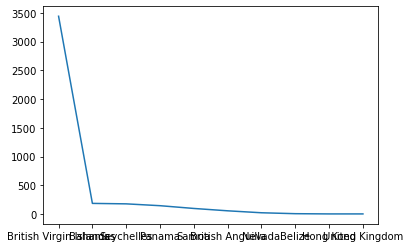

In [132]:
plt.plot(country,val)

In [133]:


def neotocsv(filename, query,d):
    with d.session(database="neo4j") as session:
        results = session.run(query)

        # allows to put header for csv
        i = 0
        #final = []
        file = "data/"+filename
        with open(file, "w+") as f:

            for record in results:

                # write header keys
                if i == 0:
                    i += 1
                    head = ""

                    for k in record.keys():
                        k = str(k).replace(",","")
                        head += k + ","
                    
                    lastCommaIndex = head.rfind(",")
                    newHead = head[:lastCommaIndex] + "\n"
                    f.write(newHead)

                # addes data to CSV
                data = ""
                for v in record.values():
                    v = str(v).replace(",","")
                    data += str(v) + ","

                lastCommaIndex = data.rfind(",")
                newData = data[:lastCommaIndex] + "\n"
                f.write(newData)
                
                #final.append(record.values()[0])
                
                
            

    d.close()

In [134]:
entities = pd.read_csv("data/num_bear.csv")

In [135]:
entities

,entity,num_bearer
0,VELA GAS INVESTMENTS LTD.,492.0
1,GNG LTD.,200.0
2,BOB AGENTS LIMITED,165.0
3,3 DIP S.A.,110.0
4,INGELSA LTD.,107.0
...,...,...
30693,CHORLEY SERVICES LIMITED,1.0
30694,BEAUVIER LTD.,1.0
30695,ATALAMA S.A.,1.0
30696,TETRA INTERNATIONAL LTD.,1.0


In [136]:
name_country = """MATCH p =(e:Entity)
WHERE e.sourceID = "Panama Papers"
RETURN e.name, e.countries"""
neotocsv("country.csv", name_country,driver)

In [137]:
entity_countries = pd.read_csv("data/country.csv")
entity_countries

,e.name,e.countries
0,TIANSHENG INDUSTRY AND TRADING CO. LTD.,Hong Kong
1,NINGBO SUNRISE ENTERPRISES UNITED CO. LTD.,Hong Kong
2,HOTFOCUS CO. LTD.,Hong Kong
3,SKY-BLUE GIFTS & TOYS CO. LTD.,Hong Kong
4,FORTUNEMAKER INVESTMENTS CORPORATION,Hong Kong
...,...,...
213628,MILLION TECH DEVELOPMENT LTD.,Hong Kong
213629,FAITH CONNECTION INTERNATIONAL LTD.,Hong Kong
213630,LARK OVERSEAS INVESTMENT LIMITED,Hong Kong
213631,ASTRA SKIES LIMITED,United Arab Emirates


In [138]:
country_cpi = pd.read_csv("data/cpi2015.csv")
country_cpi

,Country,CPI score 2015,Sources 2015,Standard error 2015
0,Denmark,91,7.0,2.16
1,New Zealand,91,7.0,2.32
2,Finland,90,7.0,1.77
3,Singapore,85,8.0,2.02
4,Sweden,89,7.0,1.71
...,...,...,...,...
190,Puerto Rico,63,NaN,NaN
191,Andorra,42,NaN,NaN
192,Samoa,52,NaN,NaN
193,Côte d'Ivoire,32,NaN,NaN


In [139]:
entities_w_cpi = entity_countries.merge(country_cpi, how='left', left_on="e.countries", right_on ='Country')
entities_w_cpi 

,e.name,e.countries,Country,CPI score 2015,Sources 2015,Standard error 2015
0,TIANSHENG INDUSTRY AND TRADING CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
1,NINGBO SUNRISE ENTERPRISES UNITED CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
2,HOTFOCUS CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
3,SKY-BLUE GIFTS & TOYS CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
4,FORTUNEMAKER INVESTMENTS CORPORATION,Hong Kong,Hong Kong,75.0,7.0,2.48
...,...,...,...,...,...,...
213653,MILLION TECH DEVELOPMENT LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
213654,FAITH CONNECTION INTERNATIONAL LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
213655,LARK OVERSEAS INVESTMENT LIMITED,Hong Kong,Hong Kong,75.0,7.0,2.48
213656,ASTRA SKIES LIMITED,United Arab Emirates,United Arab Emirates,70.0,7.0,5.07


In [140]:
entities_w_cpi.isna().sum() #3,115 recovered; went down to 40,154; recovered 30,671 more

e.name                     4
e.countries                0
Country                 9483
CPI score 2015          9483
Sources 2015           40176
Standard error 2015    40176
dtype: int64

In [141]:
sum(entities_w_cpi["e.countries"]==entities_w_cpi["Country"])

204175

In [142]:
null_countries = entities_w_cpi[entities_w_cpi["Country"].isna()]
null_countries

,e.name,e.countries,Country,CPI score 2015,Sources 2015,Standard error 2015
97,MOROCCAN PROPERTIES LTD.,Gibraltar,NaN,NaN,NaN,NaN
131,MILE OAK LIMITED,Isle of Man,NaN,NaN,NaN,NaN
143,SPRING PINE LIMITED,Isle of Man,NaN,NaN,NaN,NaN
150,POPPLEWELL LIMITED,Isle of Man,NaN,NaN,NaN,NaN
168,LAKEVIEW COMPANY INC.,Gibraltar,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
213569,WATERSHIP INVESTMENT S.A.,Gibraltar,NaN,NaN,NaN,NaN
213594,SARKENT INTERNATIONAL LTD.,British Virgin Islands,NaN,NaN,NaN,NaN
213597,ARPS FINANCIAL INC.,British Virgin Islands,NaN,NaN,NaN,NaN
213598,INVEST TECHNOLOGY INC.,British Virgin Islands,NaN,NaN,NaN,NaN


In [143]:
import matplotlib.pyplot as plt



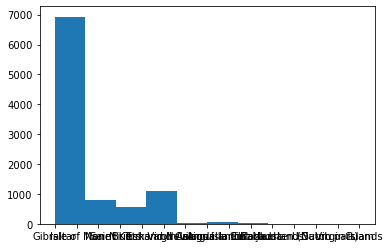

In [144]:
plt.hist(null_countries["e.countries"])
plt.show()

In [145]:
num_country_list = list(set(null_countries["e.countries"]))
num_country_list

['Antigua and Barbuda',
 'Saint Kitts and Nevis',
 'None',
 'Isle of Man',
 'Nauru',
 'British Virgin Islands',
 'Gibraltar',
 'U.S. Virgin Islands',
 'Curaçao',
 'Turks and Caicos Islands',
 'Guam',
 'Cook Islands',
 'Anguilla',
 'Niue',
 'Sint Maarten (Dutch part)']

In [146]:
len(num_country_list)

15

In [147]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [148]:
# Create an URL object
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_tax_rates'# Create object page
page = requests.get(url)

In [149]:
# parser-lxml = Change html to Python friendly format
# Obtain page's information
soup = BeautifulSoup(page.text, 'lxml')
soup

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of countries by tax rates - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"b6ffbc29-7842-42ba-a97a-d896c40c19bb","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_countries_by_tax_rates","wgTitle":"List of countries by tax rates","wgCurRevisionId":1081493866,"wgRevisionId":1081493866,"wgArticleId":1276863,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 maint: archived copy as title","Webarchive template wayback links","CS1 Spanish-language sources (

In [150]:
# table1 = soup.find("table", class="wikitable sortable tpl-blanktable jquery-tablesorter")
# table1 = soup.find("table",{"class":"wikitable sortable tpl-blanktable jquery-tablesorter"})
table1 = soup.find('table',{'class':"wikitable"})
table1

<table class="wikitable sortable tpl-blanktable">
<tbody><tr class="is-sticky">
<th scope="col;" style="width: 16%;">Country
</th>
<th data-sort-type="number" scope="col;" style="width: 17%;"><a href="/wiki/Corporate_tax" title="Corporate tax">Corporate tax</a> (excl. dividend taxes)
</th>
<th data-sort-type="number" scope="col;" style="width: 17%;"><a href="/wiki/Income_tax" title="Income tax">Individual Income tax</a> <span style="font-size:85%;">(lowest marginal rate)</span>
</th>
<th data-sort-type="number" scope="col;" style="width: 17%;"><a href="/wiki/Income_tax" title="Income tax">Individual Income tax</a> <span style="font-size:85%;">(highest marginal rate)</span><sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th data-sort-type="number" scope="col;" style="width: 17%;"><a href="/wiki/Value-added_tax" title="Value-added tax">VAT or GST</a> or <a href="/wiki/Sales_tax" title="Sales tax">sales tax</a>
</th>
<th>Capital Gains Tax
</th>
<th class=

In [151]:
df=pd.read_html(str(table1))
# convert list to dataframe
df=pd.DataFrame(df[0])
# print(df.head())
df

,Country,Corporate tax (excl. dividend taxes),Individual Income tax (lowest marginal rate),Individual Income tax (highest marginal rate)[1],VAT or GST or sales tax,Capital Gains Tax,Further reading
0,Afghanistan,20%[2],0%[3],20%[3],0%[4],NaN,Taxation in Afghanistan
1,Albania,15%[5],0%[6],23%[6],20% (standard rate)6% (tourism services)[7],NaN,Taxation in Albania
2,Algeria,26% (highest rate)19% (lowest rate)[8],0%[9],35%[9],19% (standard rate)[10]9% (basic items)[10],NaN,Taxation in Algeria
3,American Samoa,34% [5],4%[11][12],6%[12],0%[13][12],NaN,Taxation in American Samoa
4,Andorra,10%[14],0%[15],10%[15],4.5% (standard rate)9.5% (banking services)2.5...,NaN,Taxation in Andorra
...,...,...,...,...,...,...,...
220,British Virgin Islands,0%[217],0%,0%,NaN,NaN,Taxation in the British Virgin Islands
221,U.S. Virgin Islands,10%,{{}},{{}},{{}},NaN,Taxation in United States Virgin Islands
222,Yemen,20%[218],10%,15%,2%,NaN,Taxation in Yemen
223,Zambia,35%,10%,30%,16%,NaN,Taxation in Zambia


In [152]:
corporate_taxes = df.drop(df.columns[2:], axis=1)
corporate_taxes

,Country,Corporate tax (excl. dividend taxes)
0,Afghanistan,20%[2]
1,Albania,15%[5]
2,Algeria,26% (highest rate)19% (lowest rate)[8]
3,American Samoa,34% [5]
4,Andorra,10%[14]
...,...,...
220,British Virgin Islands,0%[217]
221,U.S. Virgin Islands,10%
222,Yemen,20%[218]
223,Zambia,35%


In [153]:
corporate_taxes["Corporate tax (excl. dividend taxes)"] = corporate_taxes["Corporate tax (excl. dividend taxes)"].str.split("%").str[0]
corporate_taxes

,Country,Corporate tax (excl. dividend taxes)
0,Afghanistan,20
1,Albania,15
2,Algeria,26
3,American Samoa,34
4,Andorra,10
...,...,...
220,British Virgin Islands,0
221,U.S. Virgin Islands,10
222,Yemen,20
223,Zambia,35


In [154]:
corporate_taxes = pd.read_csv('data/corporate_taxes.csv')
# corporate_taxes['Corporate tax (excl. dividend taxes)'] = corporate_taxes['Corporate tax (excl. dividend taxes)'].astype(int)
corporate_taxes['Corporate tax (excl. dividend taxes)'].isnull().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [155]:
import numpy as np

In [156]:
# corporate_taxes.to_csv("data/corporate_taxes.csv")

In [157]:
bear_per_entity = pd.read_csv("data/num_bear_plus_country.csv")
bear_per_entity

,E.name,E.countries,total
0,DECARIA COMPANY LTD.,Samoa,2
1,DRAGONTLY TELECOMMUNICATIONS INC.,Samoa,15
2,FOREVER FAITH FINANCE LTD.,Seychelles,20
3,AGAMENON INVESTMENTS LIMITED,Spain,2
4,FOXBOURNE LIMITED,Luxembourg,2
...,...,...,...
30813,Middlebeers Ltd.,United States;Not identified,1
30814,Trans Yula Corporation,Panama;British Virgin Islands,1
30815,JAFLC Capital Management Ltd.,United States;Not identified,1
30816,Brickside Limited,Not identified;Canada,1


In [158]:
def split(col_name):
    col_name = col_name.split(';')
    if len(col_name) < 2:
        return col_name[0]
    elif col_name[0] == 'Not identified':
        return col_name[1]
    elif col_name[1] == 'Not identified':
        return col_name[0]
    elif col_name[0] != 'Not identified' and col_name[1] != 'Not identified':
        return col_name[0]

In [159]:
bear_per_entity['E.countries'] = bear_per_entity['E.countries'].fillna("")
bear_per_entity['E.countries'] = bear_per_entity['E.countries'].apply(split)

In [160]:
bear_per_entity

,E.name,E.countries,total
0,DECARIA COMPANY LTD.,Samoa,2
1,DRAGONTLY TELECOMMUNICATIONS INC.,Samoa,15
2,FOREVER FAITH FINANCE LTD.,Seychelles,20
3,AGAMENON INVESTMENTS LIMITED,Spain,2
4,FOXBOURNE LIMITED,Luxembourg,2
...,...,...,...
30813,Middlebeers Ltd.,United States,1
30814,Trans Yula Corporation,Panama,1
30815,JAFLC Capital Management Ltd.,United States,1
30816,Brickside Limited,Canada,1


In [161]:
bear_per_entity.to_csv("data/bear_shares_per_entity.csv")

In [162]:
corporate_taxes[np.isnan(corporate_taxes['Corporate tax (excl. dividend taxes)'])] # Niue **

,Unnamed: 0,Country,Corporate tax (excl. dividend taxes)
62,62,Eritrea,NaN
104,104,Kiribati,NaN
120,120,Madagascar,NaN
135,135,Montserrat,NaN
140,140,Nauru,NaN
149,149,Norfolk Island,NaN
154,154,Palau,NaN
171,171,Saint Pierre and Miquelon,NaN
202,202,Tokelau,NaN


In [163]:
bear_per_entity.groupby('E.countries')['total'].sum()

E.countries
                        162
Andorra                 938
Anguilla                  4
Antigua and Barbuda      23
Argentina                60
                       ... 
United Kingdom         1256
United States           790
Uruguay                2142
Uzbekistan                4
Venezuela               430
Name: total, Length: 106, dtype: int64

In [164]:
bear_per_entity.groupby('E.countries')['total'].sum()
bear_per_country = pd.DataFrame()
bear_per_country['Total'] = bear_per_entity.groupby('E.countries')['total'].sum()
bear_per_country

,Total
E.countries,
,162
Andorra,938
Anguilla,4
Antigua and Barbuda,23
Argentina,60
...,...
United Kingdom,1256
United States,790
Uruguay,2142


In [165]:
bear_per_country = bear_per_country.reset_index()
bear_per_country = bear_per_country.drop(0)
bear_per_country

,E.countries,Total
1,Andorra,938
2,Anguilla,4
3,Antigua and Barbuda,23
4,Argentina,60
5,Aruba,5
...,...,...
101,United Kingdom,1256
102,United States,790
103,Uruguay,2142
104,Uzbekistan,4


In [166]:
corporate_taxes

,Unnamed: 0,Country,Corporate tax (excl. dividend taxes)
0,0,Afghanistan,20.0
1,1,Albania,15.0
2,2,Algeria,26.0
3,3,American Samoa,34.0
4,4,Andorra,10.0
...,...,...,...
221,221,U.S. Virgin Islands,10.0
222,222,Yemen,20.0
223,223,Zambia,35.0
224,224,Zimbabwe,25.0


In [180]:
bear_per_country_tax = bear_per_country.merge(corporate_taxes, how='left', left_on="E.countries", right_on ='Country')
bear_per_country_tax

,E.countries,Total,Unnamed: 0,Country,Corporate tax (excl. dividend taxes)
0,Andorra,938,4,Andorra,10.0
1,Anguilla,4,6,Anguilla,0.0
2,Antigua and Barbuda,23,7,Antigua and Barbuda,25.0
3,Argentina,60,8,Argentina,30.0
4,Aruba,5,10,Aruba,25.0
...,...,...,...,...,...
100,United Kingdom,1256,213,United Kingdom,19.0
101,United States,790,214,United States,21.0
102,Uruguay,2142,215,Uruguay,25.0
103,Uzbekistan,4,216,Uzbekistan,12.0


In [188]:
corporate_taxes_country = pd.DataFrame()
corporate_taxes_country['Country'] = bear_per_country_tax['Country']
corporate_taxes_country['Bear shares'] = bear_per_country_tax['Total']
corporate_taxes_country['Corporate tax'] = bear_per_country_tax['Corporate tax (excl. dividend taxes)']
corporate_taxes_country

,Country,Bear shares,Corporate tax
0,Andorra,938,10.0
1,Anguilla,4,0.0
2,Antigua and Barbuda,23,25.0
3,Argentina,60,30.0
4,Aruba,5,25.0
...,...,...,...
100,United Kingdom,1256,19.0
101,United States,790,21.0
102,Uruguay,2142,25.0
103,Uzbekistan,4,12.0


In [ ]:

# corporate_taxes.to_csv("data/corporate_taxes.csv")

In [189]:
corporate_taxes_country.to_csv("data/bear_shares_and_corporate_tax_per_country")